In [0]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
import torchvision
import torchvision.transforms as transforms


%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

%cd /content/gdrive/My\ Drive/Deep_Learning/
with open("augmented_healthy_data.pickle", 'rb') as handle:
    healthy_samples = pickle.load(handle)

with open("augmented_splinter_data.pickle", 'rb') as handle:
    splinter_samples = pickle.load(handle)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Deep_Learning


In [0]:
def resized_pictures_coord_to_sigmoid(x_y):
  # To avoid predicting x and y outside of the frame. The output of the network will be squeezed between 0-1.
  # In height Pixel 21 = 0 | Pixel 89 = 1
  # In width  Pixel 21 = 0 | Pixel 44 = 1 
  # This is because the input size is 110 x 65. And the crop is 42x42. (21 to from middle to each size)
  
  # new_metric = [0 1];
  # height = [21 89];
  # width = [21 44];
  # coeffs_h = polyfit(height, new_metric, 1);
  # coeffs_w = polyfit(width, new_metric, 1);
  
  return np.round(x_y * [0.0434782608695652, 0.0147058823529412] - [0.913043478260871, 0.308823529411765], 4)

def squeezed_to_coords(x_y_norm):
  # To go from 0 - 1 to the coodinate system
  # h_coeffs = polyfit(new_metric, height, 1);
  # w_coeffs = polyfit(new_metric, width, 1);

  return np.round(x_y_norm * [23, 68] + [21, 21], 0).astype(int)

In [0]:
test_split = 0.8

healthy_train_size = int(healthy_samples.shape[0]*test_split)
splinter_train_size = int(splinter_samples.shape[0]*test_split)

training_samples = np.r_[(healthy_samples[:healthy_train_size], splinter_samples[:splinter_train_size])]
test_samples = np.r_[(healthy_samples[healthy_train_size:], splinter_samples[splinter_train_size:])]

print("Training samples: " + str(training_samples.shape[0]) + " | Including : " + str(healthy_train_size) + " healthy samples and " + str(splinter_train_size) + " splintered samples.")
print("Testing samples:  " + str(test_samples.shape[0]) + " | Including : " + str(healthy_samples[healthy_train_size:].shape[0]) + " healthy samples and " + str(splinter_samples[splinter_train_size:].shape[0]) + " splintered samples.")


Training samples: 524 | Including : 265 healthy samples and 259 splintered samples.
Testing samples:  132 | Including : 67 healthy samples and 65 splintered samples.


In [0]:
np.random.seed(45)
np.random.shuffle(training_samples)
np.random.shuffle(test_samples)

print(training_samples[0:10, 3])
print(training_samples[0:10, 4])

[1 0 1 1 1 1 0 0 1 1]
['Augmented' 'Original' 'Original' 'Augmented' 'Original' 'Augmented'
 'Original' 'Augmented' 'Augmented' 'Augmented']


In [0]:
# Here the pictures and X, Y labels will be disassembled from the remaining data. To train the localizer.
train_pictures = []
train_xylabels = []
for data in zip(training_samples[:, 1], training_samples[:, 2]):
  train_pictures.append(data[0])
  train_xylabels.append(resized_pictures_coord_to_sigmoid(data[1]))

train_pictures = np.array(train_pictures)
train_xylabels = np.array(train_xylabels)

test_pictures = []
test_xylabels = []
for data in zip(test_samples[:, 1], test_samples[:, 2]):
  test_pictures.append(data[0])
  test_xylabels.append(resized_pictures_coord_to_sigmoid(data[1]))

test_pictures = np.array(test_pictures)
test_xylabels = np.array(test_xylabels)

print("Training picture shapes: " + str(train_pictures.shape))
print("Training X-Y-Label shapes: " + str(train_xylabels.shape))

Training picture shapes: (524, 110, 65, 1)
Training X-Y-Label shapes: (524, 2)


In [0]:
# Make sure the squeezing and invert-squeezing works
n = 0
print(training_samples[n, 2])
print(train_xylabels[n])
ori_xy = squeezed_to_coords(train_xylabels[n])
print(ori_xy)

[41 33]
[0.8696 0.1765]
[41 33]


In [0]:
num_outputs = train_xylabels.shape[1]
input_channels = train_pictures.shape[3]
batch_size = 10

Net = 0
net = 0

class Net(nn.Module):
    def __init__(self, num_classes, batch_size):
        super(Net, self).__init__()
        self.batch_size = batch_size
                
        # Convolutional stuff
        self.simple_conv1 = nn.Conv2d(in_channels=input_channels,
                                     out_channels=32, 
                                     kernel_size=3, 
                                     padding=1,
                                     stride = 2)
        
        self.simple_pool = nn.MaxPool2d(2, 2)
        
        self.simple_conv2 = nn.Conv2d(in_channels = 32,
                                      out_channels= 16,
                                      kernel_size = 3,
                                      padding = 1)
        
        self.simple_conv3 = nn.Conv2d(in_channels = 16,
                                      out_channels= 8,
                                      kernel_size = 3,
                                      padding = 1)

      
        self.linear1 = Linear(in_features=8*6*4,
                            out_features=90)
        self.linear2 = Linear(in_features=90,
                             out_features=30)

        self.l_out = Linear(in_features=30,
                            out_features=num_outputs,
                            bias=False)


        # Activation
        self.activation_relu = torch.nn.ReLU()
        self.activation_sigmoid = torch.nn.Sigmoid()
        
        # Regularization
        self.drop_layer_1 = torch.nn.Dropout(p=0.4)
        self.drop_layer_2 = torch.nn.Dropout(p=0.3)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.bn2 = torch.nn.BatchNorm2d(16)
        self.bn3 = torch.nn.BatchNorm2d(8)
        

    def forward(self, x):
        # Comes in B H W C (0, 1, 2, 3) comes out B C H W (0, 3, 1, 2)
        x = x.permute(0, 3, 1, 2)

        x = self.simple_conv1(x)
        x = self.bn1(x)
        x = self.activation_relu(x)
        x = self.simple_pool(x)
        
        x = self.simple_conv2(x)
        x = self.bn2(x)
        x = self.activation_relu(x)
        x = self.simple_pool(x)
        
        x = self.simple_conv3(x)
        x = self.bn3(x)
        x = self.activation_relu(x)
        x = self.simple_pool(x)

        x = x.view(-1, 8*6*4) # output dimensions from conv2 to a 1d
        
        x = self.linear1(x)
        x = self.activation_relu(x)
        x = self.drop_layer_1(x)
        
        x = self.linear2(x)
        x = self.activation_relu(x)
        x = self.drop_layer_2(x)
      
        return self.activation_sigmoid(self.l_out(x))
    
net = Net(num_outputs, batch_size)
print(net)

Net(
  (simple_conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (simple_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (simple_conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (simple_conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=192, out_features=90, bias=True)
  (linear2): Linear(in_features=90, out_features=30, bias=True)
  (l_out): Linear(in_features=30, out_features=2, bias=False)
  (activation_relu): ReLU()
  (activation_sigmoid): Sigmoid()
  (drop_layer_1): Dropout(p=0.4, inplace=False)
  (drop_layer_2): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [0]:
#Test the forward pass with dummy data

x = np.random.normal(0,1, (batch_size, 110, 65, 1)).astype('float32')
x = Variable(torch.from_numpy(x))
print(net(Variable(x)).size())

torch.Size([10, 2])


In [0]:
# CRITIRION AND OPTIMIZER
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(net.parameters(), lr=(3*1e-4 + 1e-5)/2, weight_decay=(1e-4 + 1e-8)/2)

In [0]:
import sys

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device) # Out comment on CPU

num_epoch = 200 
losses = []
losses_val = []

num_batches_train = train_pictures.shape[0] // batch_size
num_batches_val = test_pictures.shape[0] // batch_size

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epoch):  # loop over the dataset multiple times
    
    valid_acc = []
    running_loss = 0.0
    net.double() # Out comment on CPU
    net.train()

    for i in range(num_batches_train):
        # get the inputs
        slce = get_slice(i, batch_size)
        
        inputs = torch.from_numpy(train_pictures[slce])
        labels = torch.from_numpy(train_xylabels[slce])

        inputs = inputs.double()   # Out comment on CPU
        inputs = inputs.to(device) # Out comment on CPU
        
        labels = labels.double()   # Out comment on CPU
        labels = labels.to(device) # Out comment on CPU
           
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        output = net(inputs)

        loss = criterion(output, labels)

        loss.backward()
        optimizer.step()
        
        if i == num_batches_train-1:
          losses.append(loss.item())
          print('TRAINING: epoch {}, loss {}'.format(epoch, loss.item()))
    
    net.double() # Out comment on CPU    
    net.eval()   
    ### Evaluate training
    for i in range(num_batches_val):
      slce = get_slice(i, batch_size)

      inputs_x = torch.from_numpy(test_pictures[slce])
      labels_x = test_xylabels[slce]

      inputs_x = inputs_x.double()   # Out comment on CPU
      inputs_x = inputs_x.to(device) # Out comment on CPU
      
      inputs_x = Variable(inputs_x)
      
      predicted_output_x = net(inputs_x)
      predicted_output_x = predicted_output_x.to("cpu")
      predicted_output_x = predicted_output_x.detach().numpy()
      #predicted_output_x = predicted_output_x.astype(int)

      if i == 4:
        losses_val.append(loss.item())
        mse_ = (np.square(predicted_output_x - labels_x)).mean()
        print('VALIDATION: epoch {}, loss {}'.format(epoch, mse_))
  
        
print('Finished Training')

cuda:0
TRAINING: epoch 0, loss 0.04501756746283723
VALIDATION: epoch 0, loss 0.02069620154551926
TRAINING: epoch 1, loss 0.02692486597229323
VALIDATION: epoch 1, loss 0.01514722159504495
TRAINING: epoch 2, loss 0.027658703811544193
VALIDATION: epoch 2, loss 0.009419508428729012
TRAINING: epoch 3, loss 0.022129419841744387
VALIDATION: epoch 3, loss 0.007919490760121928
TRAINING: epoch 4, loss 0.012066667142699217
VALIDATION: epoch 4, loss 0.008182722426100164
TRAINING: epoch 5, loss 0.009546711886745983
VALIDATION: epoch 5, loss 0.006982477217432187
TRAINING: epoch 6, loss 0.010698627350250022
VALIDATION: epoch 6, loss 0.007703204360532445
TRAINING: epoch 7, loss 0.017321918037639265
VALIDATION: epoch 7, loss 0.0057269573719239825
TRAINING: epoch 8, loss 0.0063041618071426175
VALIDATION: epoch 8, loss 0.00518525202098939
TRAINING: epoch 9, loss 0.010948495368532585
VALIDATION: epoch 9, loss 0.006501574261102641
TRAINING: epoch 10, loss 0.008938850896477949
VALIDATION: epoch 10, loss 0.0

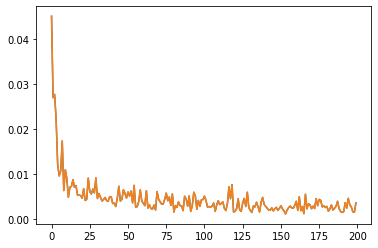

In [0]:
ep = np.arange(0, 200, 1)
plt.plot(ep, losses, ep, losses_val)

Below is just to make sure that the shuffle was correct.

In [0]:
def info_for_picture(x_y_coords, big_picture_x):
  zoom = 21
  rect_start = (x_y_coords-zoom)*10
  rect_end = (x_y_coords+zoom)*10

  big_picture_zoomed = big_picture_x[rect_start[1]:rect_end[1], rect_start[0]:rect_end[0]]

  bottom_left_x = (x_y_coords[0]*10) - zoom*10
  bottom_left_y = (x_y_coords[1]*10) - zoom*10

  rect = patches.Rectangle((bottom_left_x, bottom_left_y), zoom*2*10, zoom*2*10,
                            linewidth=1, edgecolor='r', facecolor='none')

  return rect, big_picture_zoomed

torch.Size([1, 2])
[0.36079818 0.45668309]
[29 52]


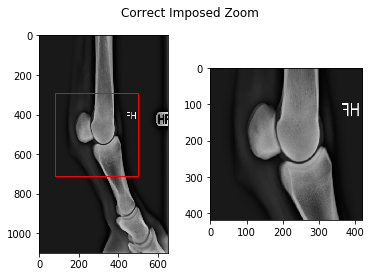

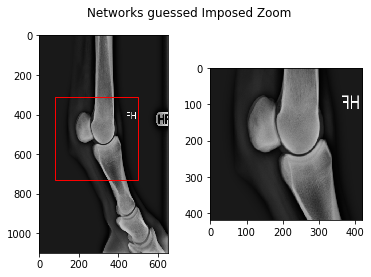

In [0]:
path = F"/content/gdrive/My Drive/Localizer_warmstarted.pt"
net.load_state_dict(torch.load(path), strict=True)

net.to("cpu")
net.double()
net.eval()

EXAPLE_NR = 9

big_picture = test_samples[EXAPLE_NR, 0]
small_picture = test_samples[EXAPLE_NR, 1]
x_y = test_samples[EXAPLE_NR, 2]

# one example
input_1 = small_picture.reshape(-1, 110, 65, 1)
input_1 = Variable(torch.from_numpy(input_1))

input_1 = input_1.double()

network_output = net(input_1)
print(network_output.shape)
network_output = network_output.detach().numpy()
network_output = network_output[0]
print(network_output)
network_output = squeezed_to_coords(network_output)

print(network_output)

rect_true, big_picture_zoomed_true = info_for_picture(x_y, big_picture)
rect_guess, big_picture_zoomed_guess = info_for_picture(network_output, big_picture)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Correct Imposed Zoom')
ax1.imshow(big_picture)
ax1.add_patch(rect_true)
ax2.imshow(big_picture_zoomed_true)
plt.show()
fig.savefig('correct_zoom.png')


fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Networks guessed Imposed Zoom')
ax1.imshow(big_picture)
ax1.add_patch(rect_guess)
ax2.imshow(big_picture_zoomed_guess)
plt.show()
fig.savefig('Network_zoom.png')

In [0]:
# Save parameters and network architecture
#import os
#path = F"/content/gdrive/My Drive/Localizer_warmstarted.pt" 

#torch.save(net.state_dict(), path)